<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Multimodal RAG with Amazon Bedrock, Amazon Nova and LangChain
</h1>

* Notebook completed by Adam Lang as part of Analytics Vidyha course "Mastering Multimodal RAG & Embeddings with Amazon Nova & Bedrock"
* Date: 3/14/2025

This notebook demonstrates how to implement a multi-modal Retrieval-Augmented Generation (RAG) system using **Amazon Bedrock with Amazon Nova and LangChain**. Many documents contain a mixture of content types, including text and images. Traditional RAG applications often lose valuable information captured in images. With the emergence of Multimodal Large Language Models (MLLMs), we can now leverage both text and image data in our RAG systems.

In this notebook, we'll explore one approach to multi-modal RAG (`Option 1`):

1. Use multimodal embeddings (such as Amazon Titan) to embed both images and text
2. Retrieve relevant information using similarity search
3. Pass raw images and text chunks to a multimodal LLM for answer synthesis using Amazon Nova

We'll use the following tools and technologies:

- [LangChain](https://python.langchain.com/v0.2/docs/introduction/) to build a multimodal RAG system
- [faiss](https://github.com/facebookresearch/faiss) for similarity search
- [Amazon Nova](https://docs.aws.amazon.com/nova/latest/userguide/what-is-nova.html ) for answer synthesis
- [Amazon Titan Multimodal Embeddings](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-multiemb-models.html) for image embeddings
- [Amazon Bedrock](https://aws.amazon.com/bedrock/) for accessing powerful AI models, like the ones above
- [pymupdf](https://pymupdf.readthedocs.io/en/latest/) to parse images, text, and tables from documents (PDFs)
- [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) for interacting with Amazon Bedrock

This approach allows us to create a more comprehensive RAG system that can understand and utilize both textual and visual information from our documents.

## Prerequisites

Before running this notebook, ensure you have the following packages and dependencies installed:

- Python 3.10 or later
- langchain
- boto3
- faiss
- pymupdf
- tabula
- tesseract
- requests

Let's get started with building our multi-modal RAG system using Amazon Bedrock!


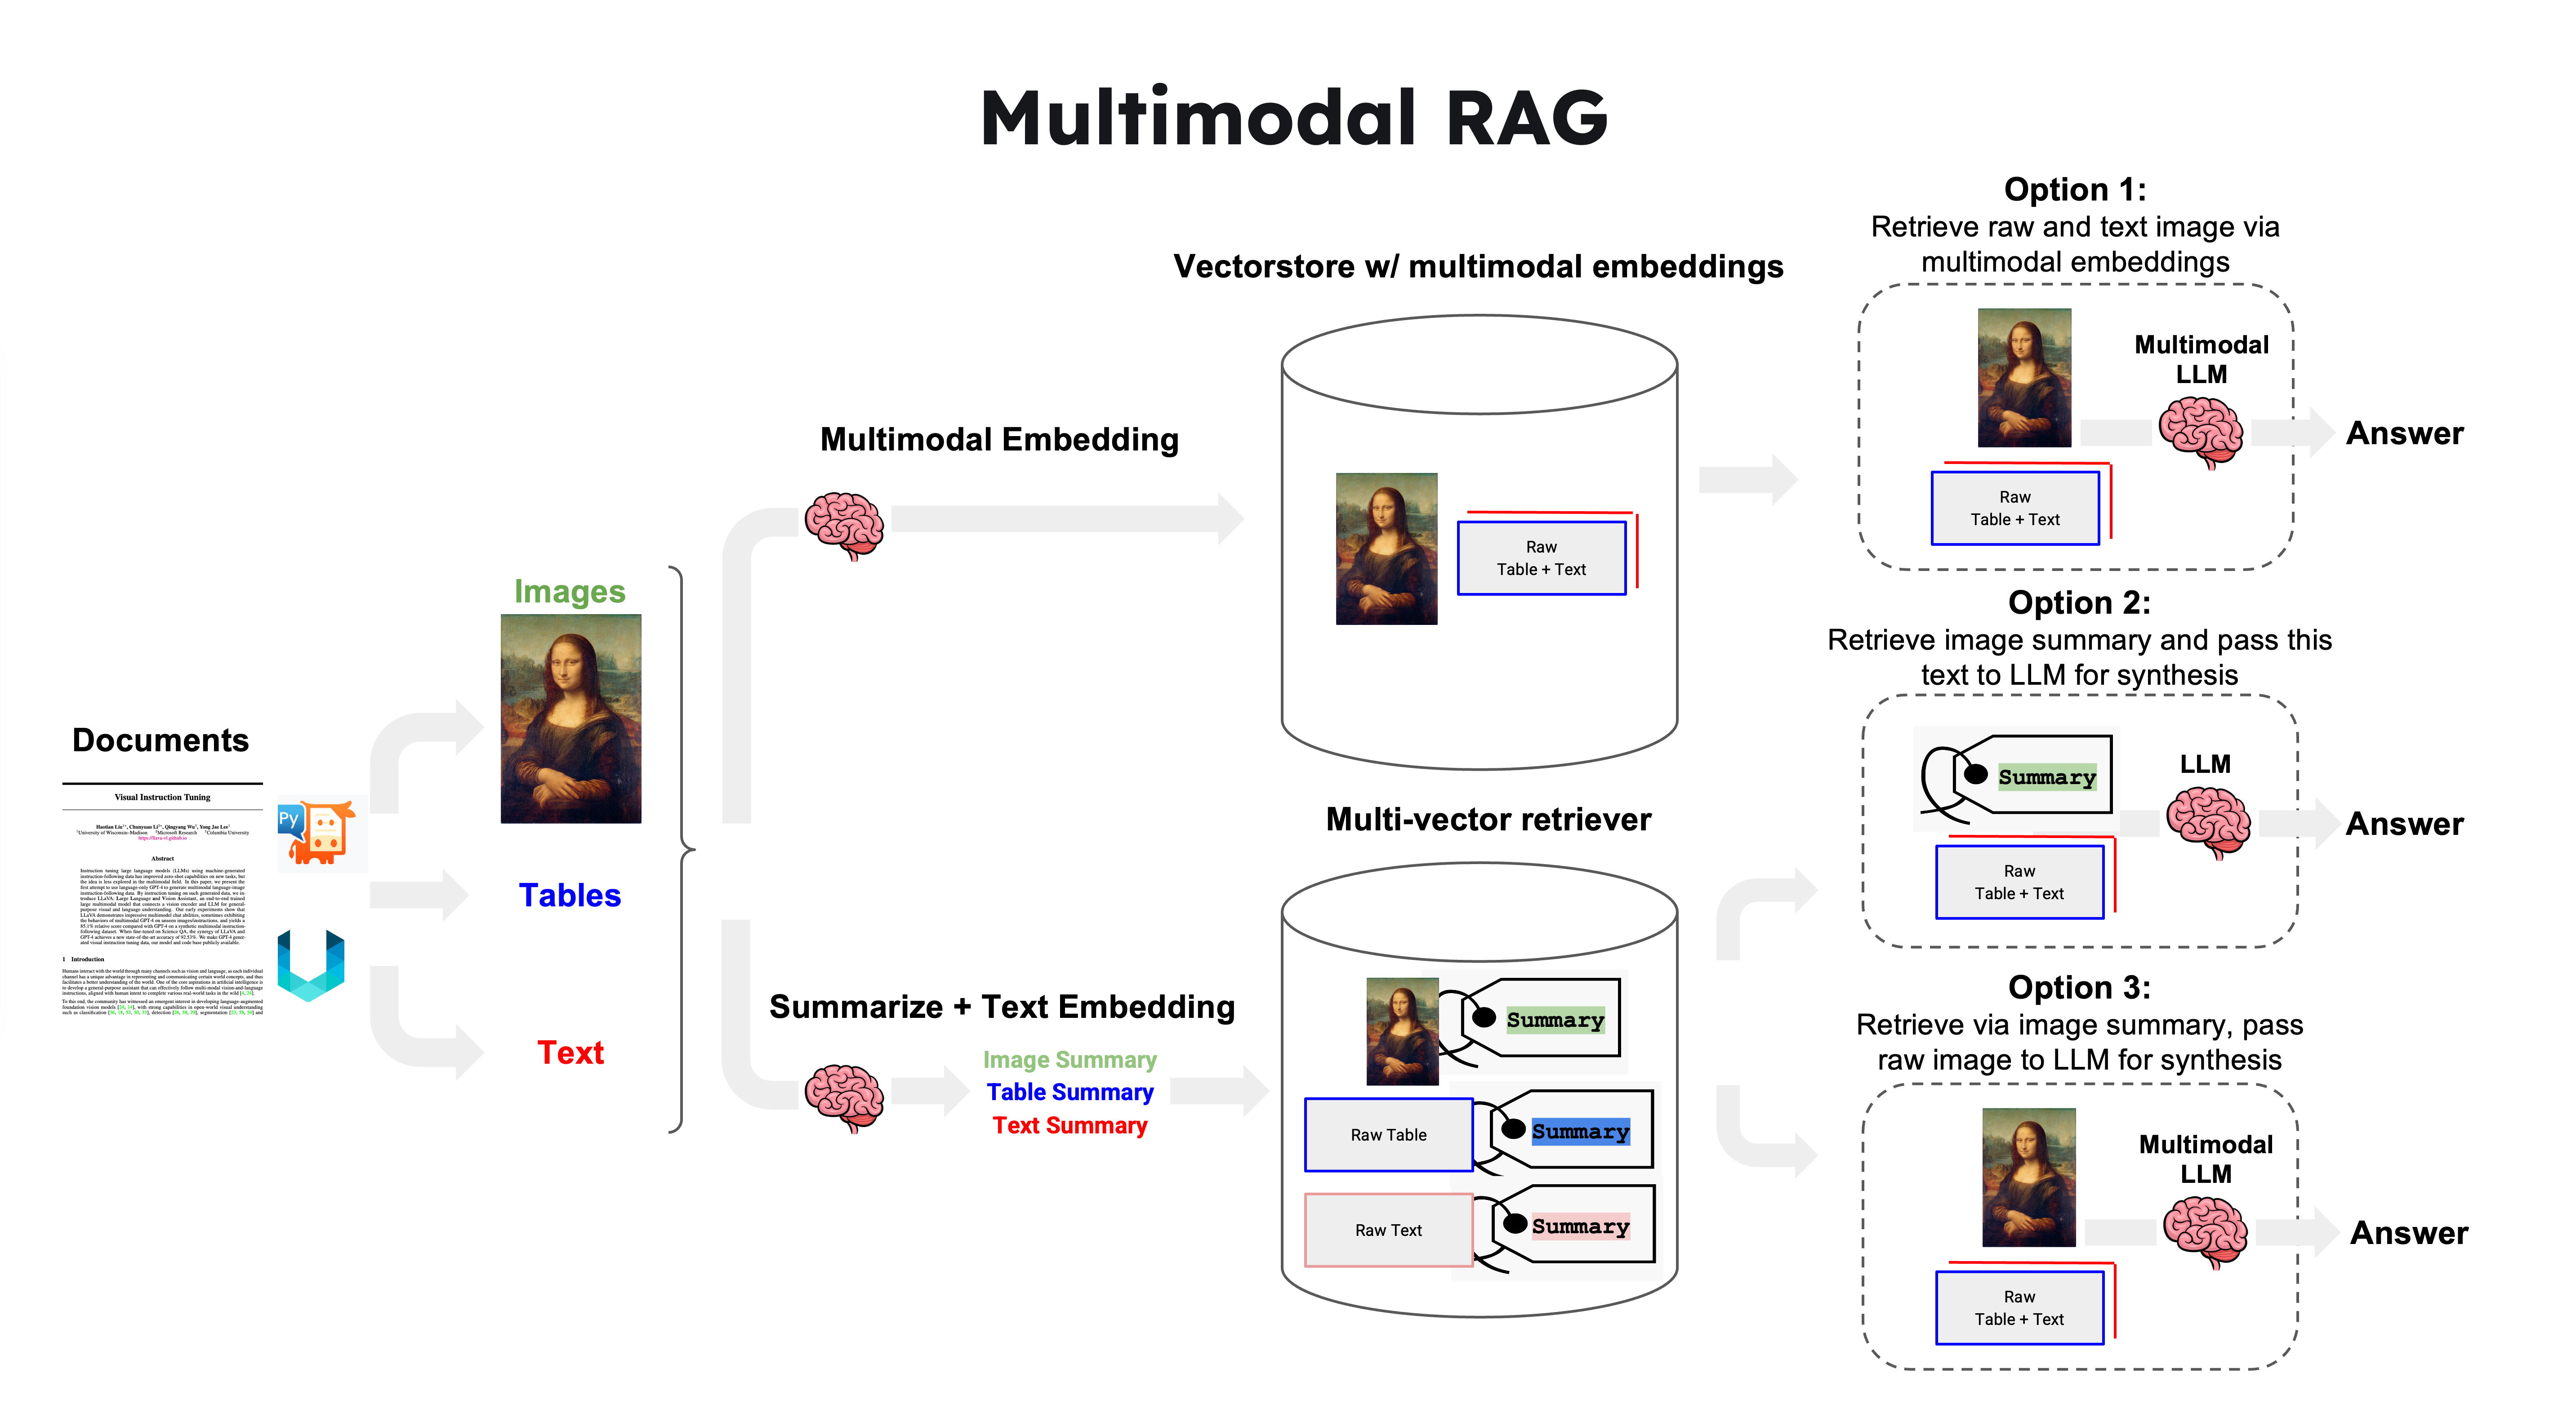

<h2 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4, #1e90ff); 
            color: white; 
            padding: 15px; 
            border-radius: 10px; 
            text-align: center; 
            font-family: 'Comic Sans MS', cursive, sans-serif; 
            text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
   Importing the libs
</h2>

Install JAVA dependencies

In [12]:
!sudo apt-get update
!sudo apt-get install -y openjdk-11-jdk

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:5 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1235 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]    
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [65.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1533 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1375 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3798 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3955 kB]
Get:12 http://security.ubuntu.com

Set the JAVA_HOME environment variable:

In [8]:
##Set the JAVA_HOME environment variable:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

Verify the Java installation

In [9]:
!java -version

openjdk version "11.0.26" 2025-01-21
OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)


Install other dependencies

In [10]:
%%capture 
!pip install --upgrade jpype1 tabula-py PyMuPDF

In [11]:
%%capture 
!pip install --upgrade boto3 requests numpy tqdm botocore langchain ipython

In [12]:
%%capture 
!pip install --upgrade faiss-cpu

In [13]:
import boto3
import tabula ## extract tables from file 
import faiss ## vector store
import json
import base64
import pymupdf ## extract images from PDF
import requests
import os
import logging
import numpy as np
import warnings
from tqdm import tqdm
from botocore.exceptions import ClientError
from langchain_text_splitters import RecursiveCharacterTextSplitter
from IPython import display


logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

<h2 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4, #1e90ff); 
            color: white; 
            padding: 15px; 
            border-radius: 10px; 
            text-align: center; 
            font-family: 'Comic Sans MS', cursive, sans-serif; 
            text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
   Data Loading
</h2>

In [14]:
# Downloading the dataset - URL of the "Attention Is All You Need" paper (Replace it with the URL of the PDF file/dataset you want to download)
url = "https://arxiv.org/pdf/1706.03762.pdf"

# Set the filename and filepath
filename = "attention_paper.pdf"
filepath = os.path.join("data", filename)

# Create the data directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Download the file
response = requests.get(url)
if response.status_code == 200:
    with open(filepath, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded successfully: {filepath}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded successfully: data/attention_paper.pdf


In [15]:
# Display the PDF file
display.IFrame(filepath, width=1000, height=600)

<h2 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4, #1e90ff); 
            color: white; 
            padding: 15px; 
            border-radius: 10px; 
            text-align: center; 
            font-family: 'Comic Sans MS', cursive, sans-serif; 
            text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
   Data Extraction
</h2>
* We will extract from the PDF file:


1. images
2. text
3. tables

Setup Helper Functions

In [16]:
# 1. Create directories for extracted images, tables, text
## directories for: images, text, tables, and page_images --> page_images is an image of an entire page (optional step)
def create_directories(base_dir):
    directories = ["images", "text", "tables", "page_images"]
    for dir in directories:
        os.makedirs(os.path.join(base_dir, dir), exist_ok=True)

### Create Wrapper functions
# 1. Process tables
def process_tables(doc, page_num, base_dir, items):
    try:
        tables = tabula.read_pdf(filepath, pages=page_num + 1, multiple_tables=True)
        if not tables:
            return
        for table_idx, table in enumerate(tables):
            table_text = "\n".join([" | ".join(map(str, row)) for row in table.values])
            table_file_name = f"{base_dir}/tables/{os.path.basename(filepath)}_table_{page_num}_{table_idx}.txt"
            with open(table_file_name, 'w') as f:
                f.write(table_text)
            items.append({"page": page_num, "type": "table", "text": table_text, "path": table_file_name})
    except Exception as e:
        print(f"Error extracting tables from page {page_num}: {str(e)}")

# 2. Process text chunks
def process_text_chunks(text, text_splitter, page_num, base_dir, items):
    chunks = text_splitter.split_text(text)
    for i, chunk in enumerate(chunks):
        text_file_name = f"{base_dir}/text/{os.path.basename(filepath)}_text_{page_num}_{i}.txt"
        with open(text_file_name, 'w') as f:
            f.write(chunk)
        items.append({"page": page_num, "type": "text", "text": chunk, "path": text_file_name})

# 3. Process images
def process_images(page, page_num, base_dir, items):
    images = page.get_images()
    for idx, image in enumerate(images):
        xref = image[0]
        pix = pymupdf.Pixmap(doc, xref)
        image_name = f"{base_dir}/images/{os.path.basename(filepath)}_image_{page_num}_{idx}_{xref}.png"
        pix.save(image_name)
        with open(image_name, 'rb') as f:
            encoded_image = base64.b64encode(f.read()).decode('utf8')
        items.append({"page": page_num, "type": "image", "path": image_name, "image": encoded_image})

# 4. Process page images
def process_page_images(page, page_num, base_dir, items):
    pix = page.get_pixmap()
    page_path = os.path.join(base_dir, f"page_images/page_{page_num:03d}.png")
    pix.save(page_path)
    with open(page_path, 'rb') as f:
        page_image = base64.b64encode(f.read()).decode('utf8')
    items.append({"page": page_num, "type": "page", "path": page_path, "image": page_image})

Create Directories -- Split/Chunk Text --- Process each page

In [17]:
doc = pymupdf.open(filepath)
num_pages = len(doc)
base_dir = "data"

# Creating the directories
create_directories(base_dir)
### Text Splitter --> RecursiveCharacterTextSplitter with overlapping chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=200, length_function=len)
items = []

# Process each page of the PDF
for page_num in tqdm(range(num_pages), desc="Processing PDF pages"):
    page = doc[page_num]
    text = page.get_text()
    process_tables(doc, page_num, base_dir, items)
    process_text_chunks(text, text_splitter, page_num, base_dir, items)
    process_images(page, page_num, base_dir, items)
    process_page_images(page, page_num, base_dir, items)

Processing PDF pages:   0%|          | 0/15 [00:00<?, ?it/s]Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Mar 14, 2025 8:02:19 PM org.apache.pdfbox.pdmodel.fo

View the outputs

In [18]:
# Looking at the first text item
[i for i in items if i['type'] == 'text'][0]

{'page': 0,
 'type': 'text',
 'text': 'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or',
 'path': 'data/text/attention_paper.pdf_text_0_0.txt'}

In [19]:
# Looking at a table item
[i for i in items if i['type'] == 'table'][2]

{'page': 7,
 'type': 'table',
 'text': 'Model | nan | nan\nnan | EN-DE EN-FR | EN-DE EN-FR\nByteNet [18] | 23.75 | nan\nDeep-Att + PosUnk [39] | 39.2 | 1.0 · 1020\nGNMT + RL [38] | 24.6 39.92 | 2.3 · 1019 1.4 · 1020\nConvS2S [9] | 25.16 40.46 | 9.6 · 1018 1.5 · 1020\nMoE [32] | 26.03 40.56 | 2.0 · 1019 1.2 · 1020\nDeep-Att + PosUnk Ensemble [39] | 40.4 | 8.0 · 1020\nGNMT + RL Ensemble [38] | 26.30 41.16 | 1.8 · 1020 1.1 · 1021\nConvS2S Ensemble [9] | 26.36 41.29 | 7.7 · 1019 1.2 · 1021',
 'path': 'data/tables/attention_paper.pdf_table_7_0.txt'}

In [20]:
# Looking at the first image item
[i for i in items if i['type'] == 'image'][0]

{'page': 2,
 'type': 'image',
 'path': 'data/images/attention_paper.pdf_image_2_0_128.png',
 'image': 'iVBORw0KGgoAAAANSUhEUgAABfAAAAi/CAIAAAANgSRZAAAACXBIWXMAAA7EAAAOxAGVKw4bAAHZTklEQVR4nOzd/88dV50n+Oc/cZwfnL/DhtBeabRSY9wZtNu0Q0jPoLHxZKHpmAyIVjzrIQNWBgsaIkMAEQKB3p3YImKT5kt3IC2wO8mOWIiTHo3EyE8jzQ8rxSPtj72Fr6g5qXvvuaeqbtWpOvV66aNWeFz31Km6Ved5zrvry8E/AQAAADArB7k7AAAAAEA7Ah0AAACAmRHoAAAAAMyMQAcAAABgZgQ6AAAAADMj0AEAAACYGYEOAAAAwMwIdAAAYLODNLm7CcAS+fUDAABNiVGOZAeAXPzWAQCA/6FblCPWAWBkft8AAMDv9I9yJh7rTLx747ATgGIYxQAAYHeas5eP5DXlvo3GTgCKYRQDAGDpeoYyc8l0JtuxMdkJQDGMYgAALNq+spjpZzrT7NXI7ASgGEYxAACWa+8RzJQznQl2aXx2AlAMoxgAAMs1RPgi0JkyOwEohlEMAICFGi55mWamM7X+ZGEnAMUwigEAsESDZi7rjU8hPphUZ3KxE4BiGMUAAFiioQMXgc402QlAMYxiAAAs0QhpS9mBzsarkKazsdvMopMAKYxiAAAszjgBRMpa+ndjWwvxwGVnCpP+T4kNdtiE7DsBYMoMWAAALM5oc/idK5pslrHxnzq0mbJRbZcfbScATJkBCwCAxRltDr9zRZPNMtb/qcOnErer1cJj7gSAKTNgAQCwLGPO4Xeua7gsI75kh553W1GH5Xf2rU8LPVcEMB1GMQAAlqV/fLDH1U02y9gYyrTqZPoHJ7sTAKbMKAYAwLL0jw/2uLrJZhnrcUyHHiZ+drI7AWDKjGIAACxL//hgj

<h2 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4, #1e90ff); 
            color: white; 
            padding: 15px; 
            border-radius: 10px; 
            text-align: center; 
            font-family: 'Comic Sans MS', cursive, sans-serif; 
            text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Generating Multimodal Embeddings
</h2>

In [21]:
# Generating Multimodal Embeddings using Amazon Titan Multimodal Embeddings model
def generate_multimodal_embeddings(prompt=None, image=None, output_embedding_length=384):
    """
    Invoke the Amazon Titan Multimodal Embeddings model using Amazon Bedrock runtime.

    Args:
        prompt (str): The text prompt to provide to the model.
        image (str): A base64-encoded image data.
    Returns:
        str: The model's response embedding.
    """
    if not prompt and not image:
        raise ValueError("Please provide either a text prompt, base64 image, or both as input")
    
    # Initialize the Amazon Bedrock runtime client
    client = boto3.client(service_name="bedrock-runtime",
                         region_name="eu-west-1")
    model_id = "amazon.titan-embed-image-v1"
    
    body = {"embeddingConfig": {"outputEmbeddingLength": output_embedding_length}}
    
    if prompt:
        body["inputText"] = prompt
    if image:
        body["inputImage"] = image

    try:
        response = client.invoke_model(
            modelId=model_id,
            body=json.dumps(body),
            accept="application/json",
            contentType="application/json"
        )

        # Process and return the response
        result = json.loads(response.get("body").read())
        return result.get("embedding")

    except ClientError as err:
        print(f"Couldn't invoke Titan embedding model. Error: {err.response['Error']['Message']}")
        return None

In [22]:
# Set embedding vector dimension
embedding_vector_dimension = 384

# Count the number of each type of item
item_counts = {
    'text': sum(1 for item in items if item['type'] == 'text'),
    'table': sum(1 for item in items if item['type'] == 'table'),
    'image': sum(1 for item in items if item['type'] == 'image'),
    'page': sum(1 for item in items if item['type'] == 'page')
}

# Initialize counters
counters = dict.fromkeys(item_counts.keys(), 0)

# Generate embeddings for all items
with tqdm(
    total=len(items),
    desc="Generating embeddings",
    bar_format=(
        "{l_bar}{bar}| {n_fmt}/{total_fmt} "
        "[{elapsed}<{remaining}, {rate_fmt}{postfix}]"
    )
) as pbar:
    
    for item in items:
        item_type = item['type']
        counters[item_type] += 1
        
        if item_type in ['text', 'table']:
            # For text or table, use the formatted text representation
            item['embedding'] = generate_multimodal_embeddings(prompt=item['text'],output_embedding_length=embedding_vector_dimension) 
        else:
            # For images, use the base64-encoded image data
            item['embedding'] = generate_multimodal_embeddings(image=item['image'], output_embedding_length=embedding_vector_dimension)
        
        # Update the progress bar
        pbar.set_postfix_str(f"Text: {counters['text']}/{item_counts['text']}, Table: {counters['table']}/{item_counts['table']}, Image: {counters['image']}/{item_counts['image']}")
        pbar.update(1)

Generating embeddings: 100%|██████████| 108/108 [00:21<00:00,  5.10it/s, Text: 83/83, Table: 7/7, Image: 3/3]


<h2 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4, #1e90ff); 
            color: white; 
            padding: 15px; 
            border-radius: 10px; 
            text-align: center; 
            font-family: 'Comic Sans MS', cursive, sans-serif; 
            text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Creating Vector Database/Index
</h2>

In [23]:
# All the embeddings
all_embeddings = np.array([item['embedding'] for item in items])

# Create FAISS Index
index = faiss.IndexFlatL2(embedding_vector_dimension)

# Clear any pre-existing index
index.reset()

# Add embeddings to the index
index.add(np.array(all_embeddings, dtype=np.float32))

In [24]:
import boto3
from langchain_aws import ChatBedrock

# Create a boto3 session with the correct region
session = boto3.Session(region_name='eu-west-1')


In [33]:
from langchain_aws import ChatBedrock

# Generating RAG response with Amazon Nova
def invoke_nova_multimodal(prompt, matched_items):
    """
    Invoke the Amazon Nova model.
    """


    # Define your system prompt(s).
    system_msg = [
                        { "text": """You are a helpful assistant for question answering. 
                                    The text context is relevant information retrieved. 
                                    The provided image(s) are relevant information retrieved."""}
                 ]

    # Define one or more messages using the "user" and "assistant" roles.
    message_content = []

    for item in matched_items:
        if item['type'] == 'text' or item['type'] == 'table':
            message_content.append({"text": item['text']})
        else:
            message_content.append({"image": {
                                                "format": "png",
                                                "source": {"bytes": item['image']},
                                            }
                                    })


    # Configure the inference parameters.
    inf_params = {"max_new_tokens": 300, 
                "top_p": 0.9,  ##instead of using temperature
                "top_k": 20}

    # Define the final message list
    message_list = [
        {"role": "user", "content": message_content}
    ]
    
    # Adding the prompt to the message list
    message_list.append({"role": "user", "content": [{"text": prompt}]})

    native_request = {
        "messages": message_list,
        "system": system_msg,
        "inferenceConfig": inf_params,
    }

    #Initialize the ChatBedrock client with the session
    model_id = "<add your inference profile here>" ## use inference profile
    client = ChatBedrock(model_id=model_id)

    # Invoke the model and extract the response body.
    response = client.invoke(json.dumps(native_request))
    model_response = response.content

    return model_response

<h2 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4, #1e90ff); 
            color: white; 
            padding: 15px; 
            border-radius: 10px; 
            text-align: center; 
            font-family: 'Comic Sans MS', cursive, sans-serif; 
            text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Test the RAG Pipeline
</h2>

In [34]:
# User Query
query = "Which optimizer was used when training the models?"

# Generate embeddings for the query
query_embedding = generate_multimodal_embeddings(prompt=query,output_embedding_length=embedding_vector_dimension)

# Search for the nearest neighbors in the vector database
distances, result = index.search(np.array(query_embedding, dtype=np.float32).reshape(1,-1), k=5)

In [35]:
# Check the result (matched chunks)
result.flatten()

array([64, 78, 54, 60, 14])

In [36]:
# Retrieve the matched items
matched_items = [{k: v for k, v in items[index].items() if k != 'embedding'} for index in result.flatten()]

# Generate RAG response with Amazon Nova
response = invoke_nova_multimodal(query, matched_items)


display.Markdown(response)

The optimizer used when training the models was the Adam optimizer, with specific parameters \(\beta_1 = 0.9\), \(\beta_2 = 0.98\), and \(\epsilon = 10^{-9}\). The learning rate was varied over the course of training according to a specific formula that adjusts the learning rate based on the step number and warmup steps.

<h2 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4, #1e90ff); 
            color: white; 
            padding: 15px; 
            border-radius: 10px; 
            text-align: center; 
            font-family: 'Comic Sans MS', cursive, sans-serif; 
            text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Your Turn: Test the RAG Pipeline
</h2>

In [37]:
# List of queries (Replace with any query of your choice)
other_queries = ["How long were the base and big models trained?",
                 "Which optimizer was used when training the models?",
                 "What is the position-wise feed-forward neural network mentioned in the paper?",
                 "What is the BLEU score of the model in English to German translation (EN-DE)?",
                 "How is the scaled-dot-product attention is calculated?",
                 ]


In [38]:
query = other_queries[0] # Replace with any query from the list above

# Generate embeddings for the query
query_embedding = generate_multimodal_embeddings(prompt=query,output_embedding_length=embedding_vector_dimension)

# Search for the nearest neighbors in the vector database
distances, result = index.search(np.array(query_embedding, dtype=np.float32).reshape(1,-1), k=5)

# Retrieve the matched items
matched_items = [{k: v for k, v in items[index].items() if k != 'embedding'} for index in result.flatten()]

# Generate RAG response with Amazon Nova
response = invoke_nova_multimodal(query, matched_items)

# Display the response
display.Markdown(response)

The base models were trained for a total of 100,000 steps, which took approximately 12 hours. The big models were trained for 300,000 steps, which took approximately 3.5 days.

<h2 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4, #1e90ff); 
            color: white; 
            padding: 15px; 
            border-radius: 10px; 
            text-align: center; 
            font-family: 'Comic Sans MS', cursive, sans-serif; 
            text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Thank you!
</h2>